/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


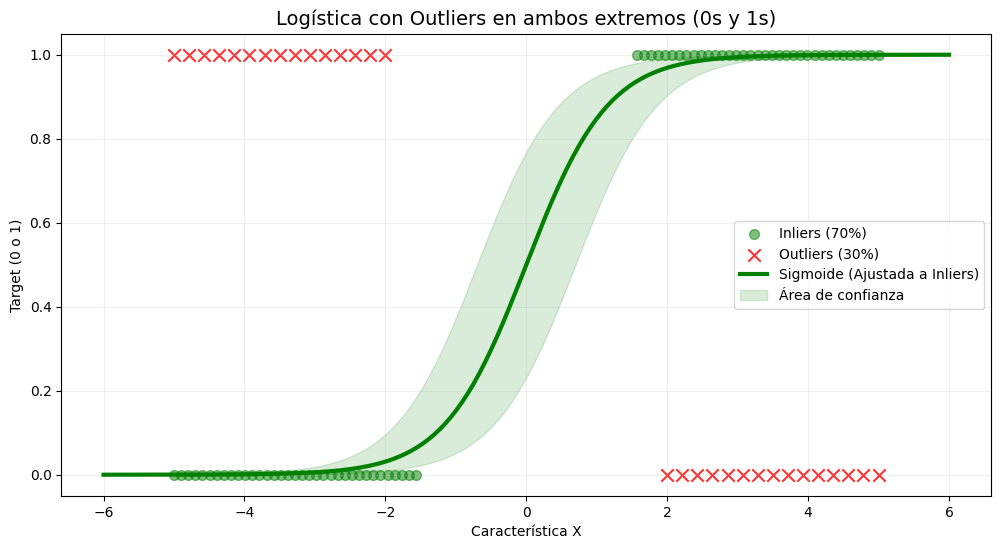

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from scipy.special import expit

# 1. GENERACIÓN DE DATOS CORREGIDA
np.random.seed(42)
n_points = 100

# Creamos un rango de X de -5 a 5
X = np.linspace(-5, 5, n_points)

# Definimos Inliers (70%): Siguen la lógica X > 0 -> 1, X <= 0 -> 0
X_inliers = np.concatenate([X[:35], X[65:]]) 
y_inliers = (X_inliers > 0).astype(int)

# Definimos Outliers (30%): 15 en cada extremo con valor opuesto al esperado
# Outliers en zona negativa (deberían ser 0, pero les ponemos 1)
X_out_neg = np.linspace(-5, -2, 15)
y_out_neg = np.ones(15)

# Outliers en zona positiva (deberían ser 1, pero les ponemos 0)
X_out_pos = np.linspace(2, 5, 15)
y_out_pos = np.zeros(15)

# Consolidar DataFrame
df = pd.DataFrame({
    'caracteristica_x': np.concatenate([X_inliers, X_out_neg, X_out_pos]),
    'target': np.concatenate([y_inliers, y_out_neg, y_out_pos]),
    'es_inlier': [1]*70 + [0]*30
})

# 2. AJUSTE DEL MODELO (Solo con inliers)
inliers_df = df[df['es_inlier'] == 1]
modelo = LogisticRegression()
modelo.fit(inliers_df[['caracteristica_x']], inliers_df['target'])

# 3. VISUALIZACIÓN
X_range = np.linspace(-6, 6, 300).reshape(-1, 1)
probabilidades = modelo.predict_proba(X_range)[:, 1]

# Cálculo de área de confianza (basada en el predictor lineal)
lineal = X_range.flatten() * modelo.coef_[0] + modelo.intercept_
banda_sup = expit(lineal + 1.2)
banda_inf = expit(lineal - 1.2)

plt.figure(figsize=(12, 6))

# Dibujar puntos Inliers (Verde) y Outliers (Rojo)
plt.scatter(df[df['es_inlier'] == 1]['caracteristica_x'], df[df['es_inlier'] == 1]['target'], 
            color='green', label='Inliers (70%)', alpha=0.5, s=50)

plt.scatter(df[df['es_inlier'] == 0]['caracteristica_x'], df[df['es_inlier'] == 0]['target'], 
            color='red', label='Outliers (30%)', alpha=0.8, s=80, marker='x')

# Dibujar Curva y Área
plt.plot(X_range, probabilidades, color='green', linewidth=3, label='Sigmoide (Ajustada a Inliers)')
plt.fill_between(X_range.flatten(), banda_inf, banda_sup, color='green', alpha=0.15, label='Área de confianza')

plt.title('Logística con Outliers en ambos extremos (0s y 1s)', fontsize=14)
plt.xlabel('Característica X')
plt.ylabel('Target (0 o 1)')
plt.legend(loc='center right')
plt.grid(True, alpha=0.2)
plt.savefig('logistic_RANSAC.jpg')
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


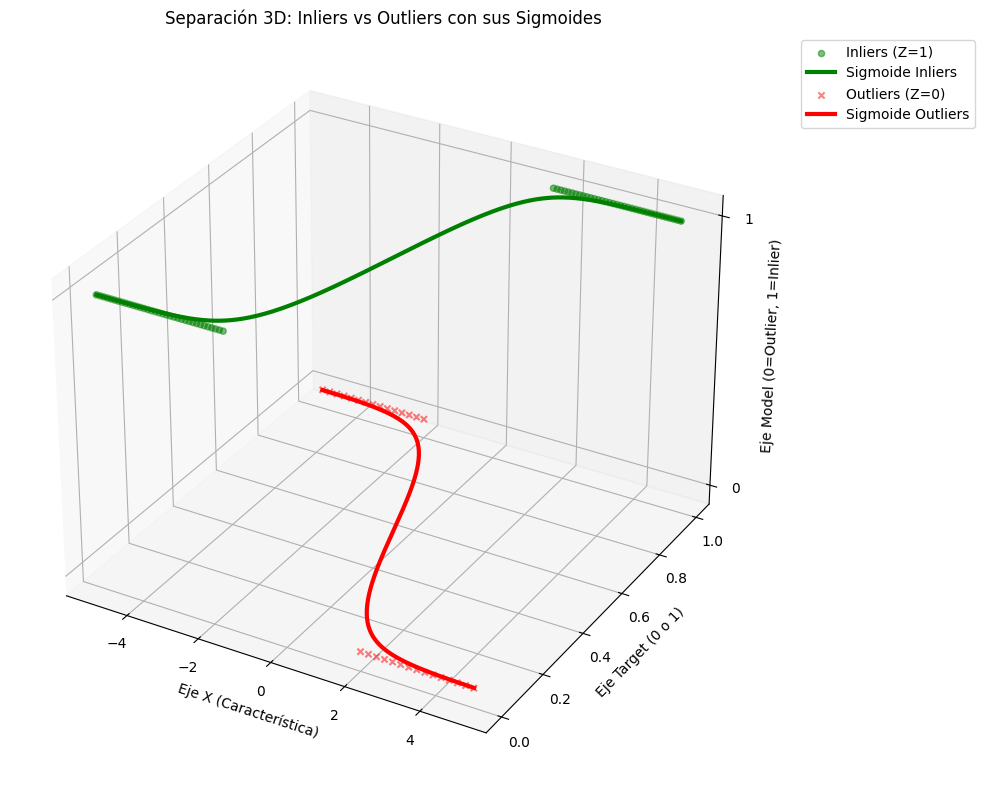

In [2]:
# 1. AJUSTE DE MODELOS
# Modelo para Inliers
model_in = LogisticRegression()
inliers = df[df['es_inlier'] == 1]
model_in.fit(inliers[['caracteristica_x']], inliers['target'])

# Modelo para Outliers (para ver cómo sería su curva descarada)
model_out = LogisticRegression()
outliers = df[df['es_inlier'] == 0]
model_out.fit(outliers[['caracteristica_x']], outliers['target'])

# 2. PREPARACIÓN DE CURVAS PARA EL GRÁFICO
x_range = np.linspace(df['caracteristica_x'].min(), df['caracteristica_x'].max(), 200)
y_prob_in = model_in.predict_proba(x_range.reshape(-1, 1))[:, 1]
y_prob_out = model_out.predict_proba(x_range.reshape(-1, 1))[:, 1]

# 3. CREACIÓN DEL GRÁFICO 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# --- Dibujar Inliers (Z = 1) ---
ax.scatter(inliers['caracteristica_x'], inliers['target'], zs=1, 
           color='green', alpha=0.5, label='Inliers (Z=1)')
ax.plot(x_range, y_prob_in, zs=1, color='green', linewidth=3, label='Sigmoide Inliers')

# --- Dibujar Outliers (Z = 0) ---
ax.scatter(outliers['caracteristica_x'], outliers['target'], zs=0, 
           color='red', alpha=0.5, label='Outliers (Z=0)', marker='x')
ax.plot(x_range, y_prob_out, zs=0, color='red', linewidth=3, label='Sigmoide Outliers')

# --- Añadir áreas transparentes (opcional para estética) ---
ax.plot_fill = lambda x, y1, y2, z: ax.add_collection3d(plt.fill_between(x, y1, y2, alpha=0.1), zs=z, zdir='z')

# Configuración de ejes
ax.set_xlabel('Eje X (Característica)')
ax.set_ylabel('Eje Target (0 o 1)')
ax.set_zlabel('Eje Model (0=Outlier, 1=Inlier)')
ax.set_title('Separación 3D: Inliers vs Outliers con sus Sigmoides')

# Ajustar los ticks del eje Z para que solo muestren 0 y 1
ax.set_zticks([0, 1])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.savefig('two_Logistic_Experts_3D.jpg')
plt.show()


En este Notebook se está creando un **modelo de mezcla** o un **"Gating Network"**.

En el cual se agregará una **tercera línea** que actúe como un **interruptor probabilístico**: esta línea decidirá, para cada punto del eje X, qué peso darle al **"Modelo Inlier" (verde)** frente al **"Modelo Outlier" (rojo)**.

Lógica aplicada: Se mantienen las dos sigmoides originales y se añadide la **Línea de Decisión (Gating Line)** en color azul eléctrico que transita entre $Z=1$ y $Z=0$.

### Conceptos Clave de la Arquitectura:

1. **Experto Inlier (Verde en $Z=1$):** Es la logística que dice: *"Si el dato es normal, yo predigo así"*.
2. **Experto Outlier (Rojo en $Z=0$):** Es la logística que dice: *"Si el dato es un outlier descarado, la lógica está invertida y yo predigo así"*.
3. **Línea de Decisión Azul (Gating):** 
    * Cuando la línea azul está arriba ($Z \approx 1$), el sistema indica: **"Confía en el modelo verde"**.
    * Cuando la línea azul cae hacia abajo ($Z \approx 0$), el sistema advierte: **"Estamos en zona de outliers, usa el modelo rojo"**.

> **Nota:** En el centro del eje X la línea azul se mantiene arriba (zona de inliers), pero en los extremos donde forzamos los outliers, la línea azul baja, **"apagando"** el modelo verde y **"encendiendo"** la relevancia del modelo rojo.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


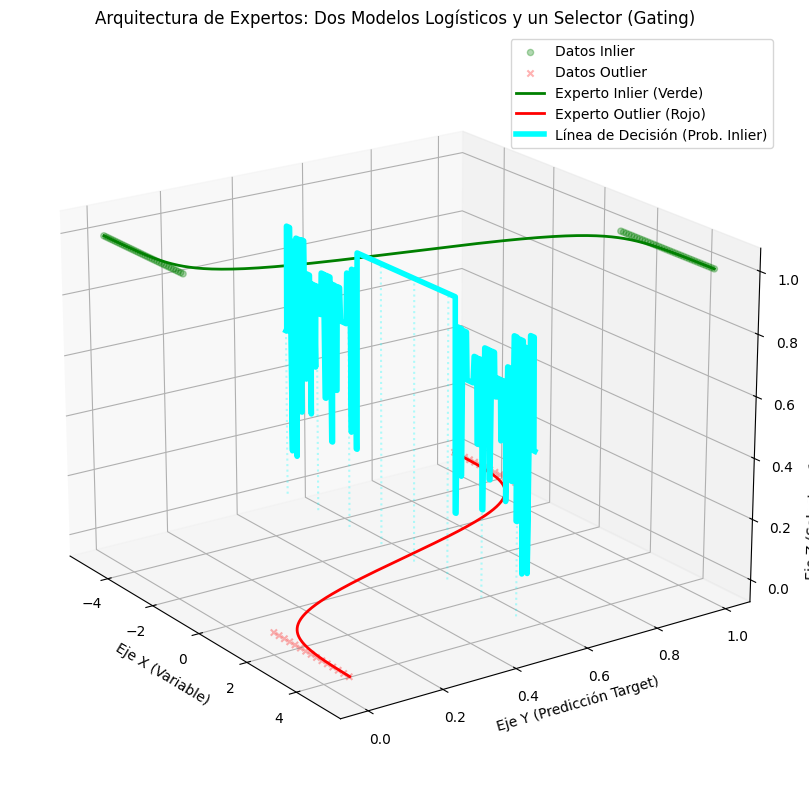

In [3]:
# 1. AJUSTE DE LOS TRES MODELOS
# Modelo A: Sigmoide Verde (solo inliers)
model_in = LogisticRegression().fit(df[df['es_inlier']==1][['caracteristica_x']], df[df['es_inlier']==1]['target'])

# Modelo B: Sigmoide Roja (solo outliers)
model_out = LogisticRegression().fit(df[df['es_inlier']==0][['caracteristica_x']], df[df['es_inlier']==0]['target'])

# Modelo C: EL GATING (Probabilidad de pertenecer al grupo inlier basado en X)
# Este modelo decide si debemos usar el modelo verde o el rojo
gating_model = GradientBoostingClassifier().fit(df[['caracteristica_x']], df['es_inlier'])

# 2. GENERACIÓN DE DATOS PARA EL GRÁFICO
x_range = np.linspace(-5, 5, 300).reshape(-1, 1)
y_prob_in = model_in.predict_proba(x_range)[:, 1]
y_prob_out = model_out.predict_proba(x_range)[:, 1]
prob_selector = gating_model.predict_proba(x_range)[:, 1] # Probabilidad de ser Inlier (Z)

# 3. GRÁFICO 3D
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# --- CAPA 1: Puntos originales ---
ax.scatter(df[df['es_inlier']==1]['caracteristica_x'], df[df['es_inlier']==1]['target'], zs=1, 
           color='green', alpha=0.3, label='Datos Inlier')
ax.scatter(df[df['es_inlier']==0]['caracteristica_x'], df[df['es_inlier']==0]['target'], zs=0, 
           color='red', alpha=0.3, marker='x', label='Datos Outlier')

# --- CAPA 2: Las dos logísticas expertas ---
# Curva verde en el plano Z=1
ax.plot(x_range.flatten(), y_prob_in, zs=1, color='green', linewidth=2, label='Experto Inlier (Verde)')
# Curva roja en el plano Z=0
ax.plot(x_range.flatten(), y_prob_out, zs=0, color='red', linewidth=2, label='Experto Outlier (Rojo)')

# --- CAPA 3: LA LÍNEA DE SELECCIÓN (GATING) ---
# Esta línea se mueve entre Z=1 y Z=0 indicando cuál modelo tiene el control
# La dibujamos a una altura Y constante (0.5) para que no se confunda con las sigmoides
ax.plot(x_range.flatten(), [0.5]*len(x_range), prob_selector, 
        color='cyan', linewidth=4, label='Línea de Decisión (Prob. Inlier)', zorder=10)

# 4. EXPLICACIÓN VISUAL (Conexiones verticales)
# Dibujamos unas pequeñas líneas para ver dónde el selector cambia de opinión
# for i in range(0, len(x_range), 40):
#     z_val = prob_selector[i]
#     ax.plot([x_range[i], x_range[i]], [0.5, 0.5], [0, z_val], color='cyan', alpha=0.3, linestyle=':')

for i in range(0, len(x_range), 40):
    # Usamos .item() para convertir el array de un solo elemento en un número escalar
    z_val = prob_selector[i].item() 
    x_val = x_range[i].item()
    
    # Ahora la línea vertical se dibuja sin errores de dimensiones
    ax.plot([x_val, x_val], [0.5, 0.5], [0, z_val], 
            color='cyan', alpha=0.3, linestyle=':')

# Configuración final
ax.set_xlabel('Eje X (Variable)')
ax.set_ylabel('Eje Y (Predicción Target)')
ax.set_zlabel('Eje Z (Selector: 1=Usa Verde, 0=Usa Rojo)')
ax.set_title('Arquitectura de Expertos: Dos Modelos Logísticos y un Selector (Gating)')
ax.view_init(elev=20, azim=-35)
ax.legend()

plt.savefig('gating Line_3D.jpg')
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


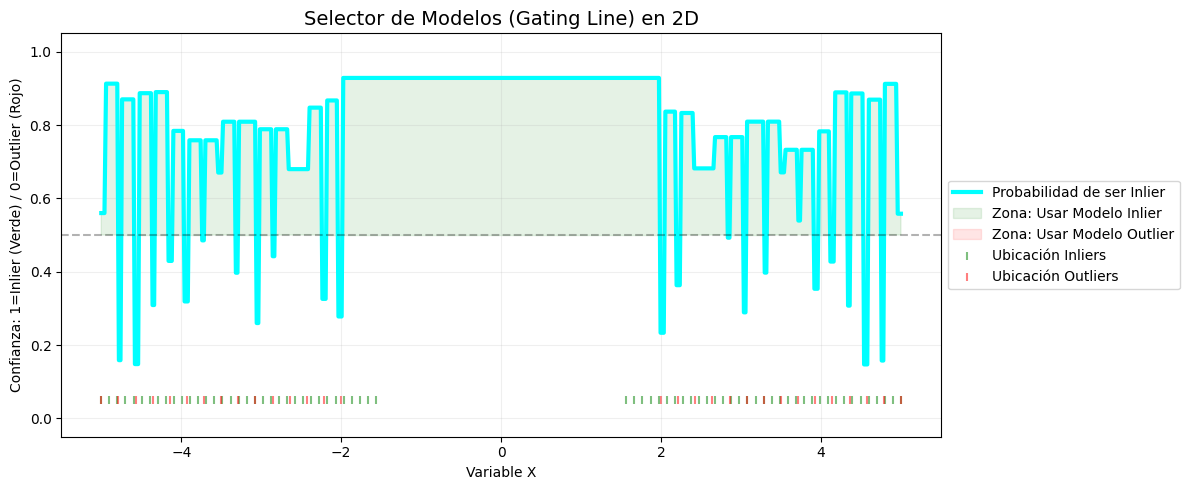

In [4]:
# 1. Preparar los datos de probabilidad (usando el gating_model entrenado antes)
x_range = np.linspace(-5, 5, 500).reshape(-1, 1)
prob_inlier = gating_model.predict_proba(x_range)[:, 1]

# 2. Crear el gráfico 2D
plt.figure(figsize=(12, 5))

# Dibujar la línea de decisión (Gating)
plt.plot(x_range, prob_inlier, color='cyan', linewidth=3, label='Probabilidad de ser Inlier')

# Rellenar las áreas para identificar visualmente qué modelo mandar
plt.fill_between(x_range.flatten(), 0.5, prob_inlier, where=(prob_inlier >= 0.5), 
                 color='green', alpha=0.1, label='Zona: Usar Modelo Inlier')
plt.fill_between(x_range.flatten(), 0.5, prob_inlier, where=(prob_inlier < 0.5), 
                 color='red', alpha=0.1, label='Zona: Usar Modelo Outlier')

# Añadir los puntos reales en la base para referencia
plt.scatter(df[df['es_inlier']==1]['caracteristica_x'], [0.05]*70, 
            color='green', marker='|', alpha=0.5, label='Ubicación Inliers')
plt.scatter(df[df['es_inlier']==0]['caracteristica_x'], [0.05]*30, 
            color='red', marker='|', alpha=0.5, label='Ubicación Outliers')

# Estética
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3)
plt.title('Selector de Modelos (Gating Line) en 2D', fontsize=14)
plt.xlabel('Variable X')
plt.ylabel('Confianza: 1=Inlier (Verde) / 0=Outlier (Rojo)')
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.2)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('gating Line_2D.jpg')
plt.show()


# Arquitectura de Mezcla de Expertos (Mixture of Experts - MoE)

Lo que hemos construido es una implementación funcional de una arquitectura **MoE**. En este sistema:
1. **Expertos (Inlier/Outlier):** Son los modelos especializados (sigmoides verde y roja).
2. **Gating Network (Línea Azul):** Es el selector probabilístico que decide qué experto tiene la razón según la zona de los datos.

Esta es la base de la IA moderna en 2025 (usada en modelos como Mixtral o GPT-4) para manejar datos complejos y ruidosos de forma eficiente.

### 📚 Recursos Recomendados (2025)
* [Mixture of Experts Explained (Hugging Face)](huggingface.co): La guía definitiva sobre routers y expertos.
* [A Comprehensive Survey of MoE (ArXiv 2025)](arxiv.org): Estado del arte en redes de compuerta.
* [PyTorch MoE Implementation](github.com): Código avanzado para redes neuronales.
